In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

Fetching from: 
<Response [200]>


In [3]:
inv = np.linalg.inv

# Generate sample time series data

Same as Linear Least Squares example.

In [4]:
t = np.linspace(0, 3, 600)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Two sensors

In [5]:
noise_mean = 0

noise_std_1 = 20
noise_std_2 = 0.5

v = []
v_std = []
noise_i = 1
n_chunks = 0
while len(v)<len(t):
    if noise_i == 1:
        noise_i = 2
        noise_std = noise_std_2
        chunk_size = 50
    else:
        noise_i = 1
        noise_std = noise_std_1
        chunk_size = 150

    v_std = np.hstack( (v_std, [noise_std]*chunk_size) )
    v = np.hstack( (v, np.random.normal(noise_mean, noise_std, chunk_size)) )
    n_chunks += 1

v_std = v_std[0:len(t)]
v = v[0:len(t)]

v_std = np.column_stack(v_std).T
v = np.column_stack(v).T

y_tilde = y+v

In [6]:
n_chunks

6

# Plotting

<Axes: xlabel='Time', ylabel='y'>

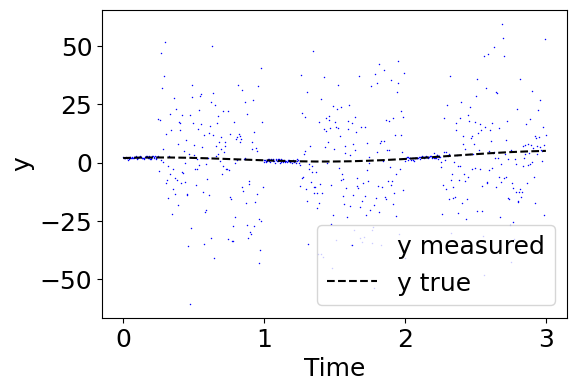

In [7]:
plot_tme(t, y, y_tilde)

# Candidate models

In [8]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Minimum Variance Estimate: Gauss-Markov Theorem

$\mathbf{\hat{x}}=(H^{\top}R^{-1}H)^{-1}H^{\top}R^{-1}\mathbf{\tilde{y}}$

In [9]:
R = np.diag( np.ravel(v_std)**2)
print(R)

[[2.5e-01 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 2.5e-01 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.5e-01 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 4.0e+02 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 4.0e+02 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 4.0e+02]]


In [10]:
y_tilde.shape

(600, 1)

In [11]:
R.shape

(600, 600)

### Model 1

In [12]:
x_1_hat = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde

In [13]:
x_1_hat

array([[1.09219916],
       [0.95508517],
       [2.05202969]])

<Axes: xlabel='Time', ylabel='y'>

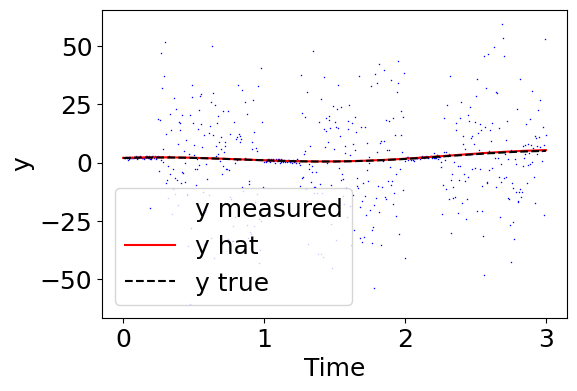

In [14]:
y_1_hat = model_1_H@x_1_hat
plot_tme(t, y, y_tilde, y_1_hat)

In [15]:
x_error = x_1_hat - x[0:3]
print(x_error)

[[ 0.09219916]
 [-0.04491483]
 [ 0.05202969]]


# Residuals

<Axes: xlabel='Time', ylabel='y'>

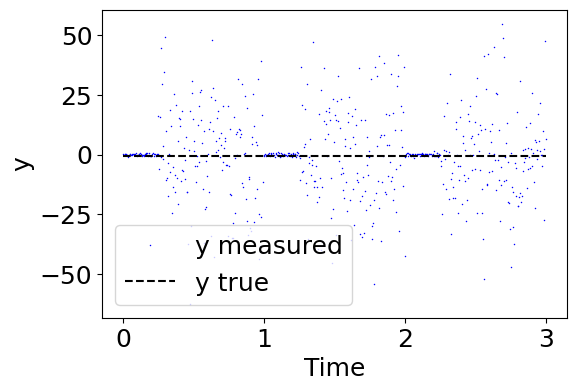

In [16]:
residuals_1 = y_tilde - y_1_hat
plot_tme(t, np.ones_like(t)*np.mean(residuals_1), residuals_1)

# Histogram of residuals

In [17]:
N1 = scipy.stats.norm(noise_mean, noise_std_1)
xr = np.linspace(-100, 100, 1000)
pdf1 = N1.pdf(xr)

N2 = scipy.stats.norm(noise_mean, noise_std_2)
pdf2 = N2.pdf(xr)

pdf = (pdf1*3 + pdf2*1) / 4

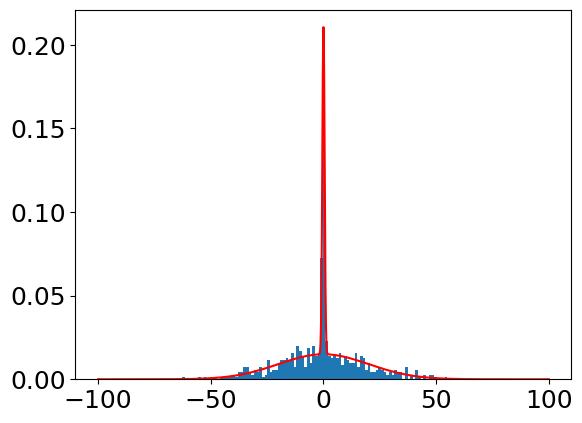

In [18]:
plt.hist(residuals_1, density=True, bins=100)
plt.plot(xr, pdf, color='red')

# Exercises

1. Use the wrong R for the minimum variance estimate. Do the errors in the estimate of x get worse?

# Solution

In [27]:
R = np.eye(len(y_tilde))

In [28]:
R.shape

(600, 600)

In [29]:
x_1_hat_R1 = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde

In [30]:
x_1_hat_R1

array([[0.71427138],
       [1.09578105],
       [3.1878323 ]])

In [34]:
diag = (np.random.normal(0,10,len(y_tilde)))**2
R = np.diag(diag)

In [35]:
R.shape

(600, 600)

In [36]:
x_1_hat_R1 = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde

In [37]:
x_1_hat_R1

array([[-0.31508177],
       [18.03478262],
       [15.54521244]])